This notebook loads a normalizing flow into a creator object and applies a selection function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches

from creator import Creator
from normalizingFlow import NormalizingFlow
from rqNeuralSplineFlow import RQNeuralSplineFlow

In [2]:
%config InlineBackend.figure_format = 'retina'

First, load the generator, which in this case will be the normalizing flow created in `redshift_flow_example.ipynb`

In [3]:
# load the generator
flow = NormalizingFlow(RQNeuralSplineFlow, file='demo_flow.pkl')

Use this flow to initialize an unbiased creator

In [4]:
# instantiate the creator
creator = Creator(flow)

Let's use this creator to generate a test set

In [5]:
%%time 
# draw the samples
samples = creator.sample(20000, include_pdf=True, seed=0)

CPU times: user 20min 54s, sys: 15min 44s, total: 36min 38s
Wall time: 6min 53s


We'll make a ''public'' test set, that consists of the galaxy magnitudes, and a ''private'' test set, which consists of the galaxy redshifts and posteriors.

In [9]:
test_public = samples[['u','g','r','i','z','y']]
test_private = samples[['redshift', 'pz_pdf']]

In [10]:
test_public.to_pickle('testset_public.pkl')
test_private.to_pickle('testset_private.pkl')

Now let's use the normalizing flow to initialize a biased creator. We create this bias by defining a selection function, which keeps galaxies with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, where $z_p$ is the ''pivot'' redshift. Below, I use $z_p = 0.8$.

In [21]:
def selection_fn(data, seed=None):
    pivot_redshift = 0.8
    probs = np.clip(pivot_redshift/data['redshift'], 0, 1)
    rng = np.random.default_rng(seed)
    idx = np.where(rng.random(size=len(data)) <= probs)
    biased_data = data.iloc[idx]
    return biased_data

In [12]:
# instantiate the creator
biased_creator = Creator(flow, selection_fn=selection_fn)

Now lets use this biased creator to make a training set

In [13]:
biased_samples = biased_creator.sample(80000, include_pdf=False, seed=0)

In [18]:
biased_samples.to_pickle('trainingset.pkl')

Let's plot a histogram of the biased and unbiased samples to make sure the selection function is doing what we want it to.

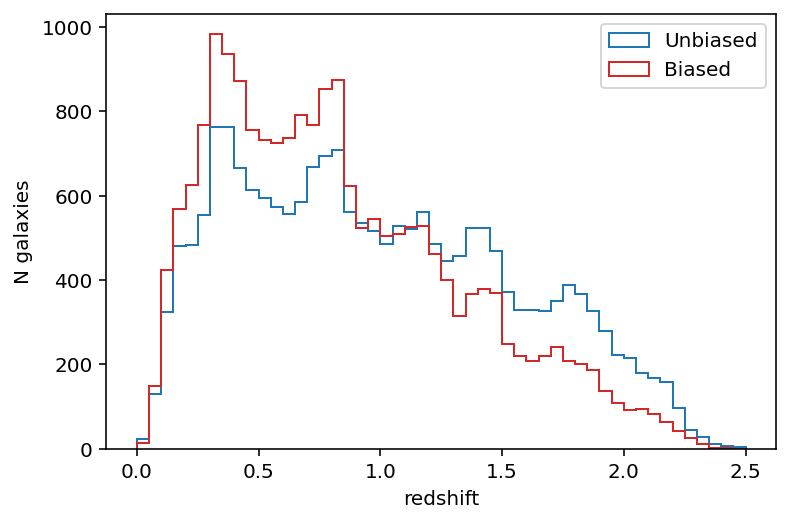

In [17]:
plt.hist(samples['redshift'], bins=50, range=(0,2.5), histtype='step', color='C0', label='Unbiased')
plt.hist(biased_samples['redshift'][:20000], bins=50, range=(0,2.5), histtype='step', color='C3', label='Biased')
plt.legend()
plt.xlabel('redshift')
plt.ylabel('N galaxies')
plt.show()